<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Key-statistics-of-primary-state-schools-in-London" data-toc-modified-id="Key-statistics-of-primary-state-schools-in-London-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Key statistics of primary state schools in London</a></span><ul class="toc-item"><li><span><a href="#Load-libraries-and-data" data-toc-modified-id="Load-libraries-and-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load libraries and data</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Key-metrics-analysis" data-toc-modified-id="Key-metrics-analysis-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Key metrics analysis</a></span></li><li><span><a href="#Choropleth-map" data-toc-modified-id="Choropleth-map-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Choropleth map</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></div>

# Key statistics of primary state schools in London

## Load libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.request import urlopen
import json

import plotly
import plotly.express as px
import plotly.graph_objects as go

#import folium
#from folium import Map, FeatureGroup, Marker, LayerControl

#turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(plotly.__version__)

4.14.3


In [3]:
#!pip install -U plotly

In [4]:
# define graphs style
plt.style.use('ggplot') 

#function for charts
def title(title):
    plt.title(title, size = 14, color = 'gray')
    plt.show()

The dataset contains 277 parameters. Lots of parameters are duplicates (for example total number of students, number of boys, number of girls). 

We will load only the following:
- `Region` to filter data on London
- `URN` - id of the school
- `LA name` - local authority name
- `School name`
- `Phase-type grouping` - to filter only primary state schools
- `District Administrative name` 
- `Academy_flag` - to exclude independent, i.e. private schools
- `Number of reception pupils (year R)` - variable to analyze
- `% of pupils known to be eligible for free school meals` - variable to analyze. By knowing number of pupils eligible for free school meals we will know the social portrait of the area, i.e. how many families are receiving social benefits from the government.
- `% of pupils classified as white British ethnic origin` - variable to analyze
- `% of pupils classified as any other white background ethnic origin` - variable to analyze
- `% of pupils whose first language is known or believed to be other than English` - variable to analyze

In [5]:
#load data

fields = ['Region', 'URN', 'LA name', 'School Name', 'Phase-type grouping',
          'District Administrative name','Academy_flag',
          'Number of reception pupils (year R)', '% of pupils known to be eligible for free school meals',
          '% of pupils classified as white British ethnic origin',
          '% of pupils classified as any other white background ethnic origin',
          '% of pupils whose first language is known or believed to be other than English']

df = pd.read_csv(r'C:\Users\Inga\Desktop\IBM Course\IBM Notebooks\9_Capstone\spc_school_level_underlying_data.csv',
                  encoding='ISO-8859-1', usecols=fields)

In [6]:
#rename columns
df.columns = ['region', 'urn', 'la', 'name', 'phase_type_grouping',
          'district','academy_flag','num_reception','perc_fsm','perc_british_origin',
              'perc_white_origin','perc_non_eng_lang']

In [7]:
df = df[(df['region'] == 'London')] #filter London schools only

df = df[(df['academy_flag'] != 'Independent')] #exclude private schools

df = df[(df['phase_type_grouping'] == 'State-funded primary')] #filter only state primary schools

df['perc_br_wh_origin'] = df['perc_british_origin'] + df['perc_white_origin'] #combine percentage of white students

#drop paramteres used for filtering
df = df.drop(columns= ['region','phase_type_grouping','perc_british_origin','perc_white_origin']) 

In [8]:
#check df
df.sample(3)

,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin
706,102187,Harrow,Grimsdyke School,Harrow,LA Maintained,89,3.0,35.0,20.9
3607,143411,Sutton,Tweeddale Primary School,Sutton,Academy,56,35.5,33.6,65.3
4828,100678,Lewisham,Deptford Park Primary School,Lewisham,LA Maintained,55,24.1,48.7,15.3


We will also need some indication of grades received by pupils.

We will use Key Stage 2 (KS2) data from gov website, specifically "Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing"

Key Stage 2 is the legal term for the four years of schooling in maintained schools in England and Wales normally known as Year 3, Year 4, Year 5 and Year 6, when the pupils are aged between 7 and 11 years. Key Stage 2 SATs are the National Curriculum tests taken by Year 6 pupils. SATs assess English reading, grammar, punctuation and spelling, and Maths. They are a great way to determine progress and act as a reflection of what your child has learned throughout their primary school years.

https://www.compare-school-performance.service.gov.uk/download-data?currentstep=datatypes&regiontype=all&la=0&downloadYear=2018-2019&datatypes=ks2

In [9]:
#load data

fields_ks2 = ['URN', 'PTRWM_HIGH']

ks2 = pd.read_csv(r'C:\Users\Inga\Desktop\IBM Course\IBM Notebooks\9_Capstone\england_ks2final.csv', 
                  usecols = fields_ks2)

ks2.columns = ['urn','perc_high_score']

In [10]:
# merge grades with the rest of the df
df = df.merge(ks2, how = 'left', on='urn')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1814 entries, 0 to 1813
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   urn                1814 non-null   object 
 1   la                 1814 non-null   object 
 2   name               1814 non-null   object 
 3   district           1814 non-null   object 
 4   academy_flag       1814 non-null   object 
 5   num_reception      1814 non-null   int64  
 6   perc_fsm           1814 non-null   float64
 7   perc_non_eng_lang  1814 non-null   float64
 8   perc_br_wh_origin  1814 non-null   float64
 9   perc_high_score    1588 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 155.9+ KB


In [12]:
# check NaN
df.isnull().mean() * 100

urn                   0.000000
la                    0.000000
name                  0.000000
district              0.000000
academy_flag          0.000000
num_reception         0.000000
perc_fsm              0.000000
perc_non_eng_lang     0.000000
perc_br_wh_origin     0.000000
perc_high_score      12.458655
dtype: float64

There is 12.5% observations / schools which are missing in KS2 data. Also the data type is object so we need to change it to float, as there are some letters instead of percentage for some schools.

Since we analyze data by local authority we can either drop schools with no data on KS2 or change the missing values to the median of the area. 

In [13]:
#remove "%"
df['perc_high_score'] = df['perc_high_score'].str.replace('%','')

#replace SUPP to none
df['perc_high_score'] = df['perc_high_score'].str.replace('SUPP','9999')

#fill in missing values as none for now
df['perc_high_score'] = df['perc_high_score'].fillna('9999')

#change type from object to float
df['perc_high_score'] = df['perc_high_score'].astype('float')

In [14]:
#find median for percentage high score for each la and create dict
dict_median = df[df['perc_high_score'] != 9999].groupby('la')['perc_high_score'].median().to_dict()

#create function
def fillnaforks2results(row):
    if row[row['perc_high_score'] != 9999]:
        return dict_median.get(row['la'])
    return row['perc_high_score']

#apply function to fill nan with median value of the local authority
df['perc_high_score'] = df.apply(fillnaforks2results, axis = 1)

In [15]:
df.sample()

,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
1336,145730,Hackney,Lubavitch Junior Boys,Hackney,Academy,14,9.8,9.8,93.8,13.0


## Exploratory data analysis

### Key metrics analysis

In [16]:
round(df.describe(),1)

,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
count,1814.0,1814.0,1814.0,1814.0,1814.0
mean,52.9,18.9,47.1,41.8,13.1
std,30.4,11.2,22.5,22.1,2.6
min,0.0,0.0,1.2,0.0,8.0
25%,30.0,10.4,28.9,23.6,11.0
50%,55.5,17.0,45.6,41.9,13.0
75%,61.0,26.6,63.6,59.1,15.0
max,239.0,64.1,100.0,100.0,29.0


In [17]:
#let's check distribution of each parametr
def distribution(x,color,name, bins):
    plt.figure(figsize=(8,4))
    sns.histplot(data = df, x = x, color = color, bins = bins)
    title(name)

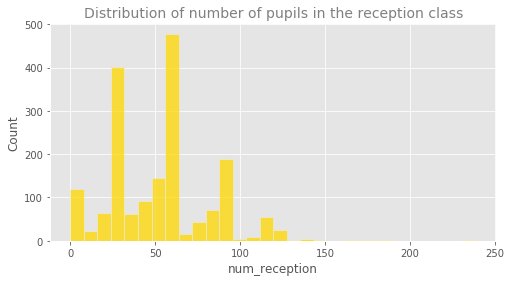

In [18]:
distribution('num_reception','gold','Distribution of number of pupils in the reception class', 30)

**Number of pupils in the reception class**

Mean is 52.9, median is 55.5, the members of a group are not very much different. And in this parameter standard deviation is highest.

The distribution looks normal, the most common number of pupils is 30, which makes sense as the max number of students in one class is 30. We can assume that sometimes there might be several reception classes each for 30 pupils, as the second peak on the histogram is 60 and around 90.

Max number is 239 and looks like outlier, where as min of 0 looks like absence of information (there are 118 schools where number of pupils in reception is zero).

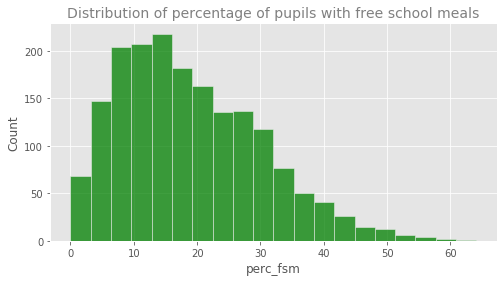

In [19]:
distribution('perc_fsm','green','Distribution of percentage of pupils with free school meals', 20)

**Percentage of pupils with free school meals**

The distribution of percentage of pupils with free school meals looks normal. The peak is around 15%.

Median is 17% and mean is 18.9%, which shows that the members of a group are not very much different.

Min is 0 (The Noam Primary School in Barnet), and max is 64.1% (Paxton Academy Sports And Science in Croydon)

In [20]:
print('School with highest percentage of free school meals')
display(df[df['perc_fsm'] == 64.1])

print('School with zero percentage of free school meals')
display(df[df['perc_fsm'] == 0])

School with highest percentage of free school meals


,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
1457,140967,Croydon,Paxton Academy Sports And Science,Croydon,Academy,18,64.1,41.4,15.5,11.0


School with zero percentage of free school meals


,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
554,146803,Barnet,The Noam Primary School,Barnet,LA Maintained,28,0.0,25.0,100.0,14.0


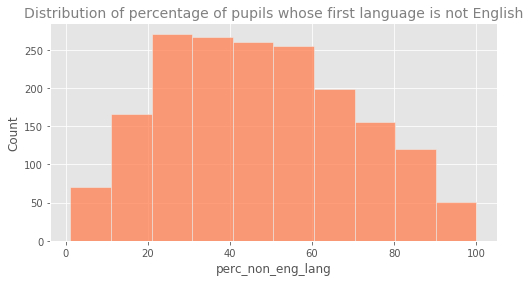

In [21]:
distribution('perc_non_eng_lang','coral','Distribution of percentage of pupils whose first language is not English', 10)

**Percentage of pupils whose first language is not English**

The distribution of percentage of pupils whose first language is not English looks normal. The peak values are 20% to 60%.

Median is 17% and mean is 18.9%, which shows that the members of a group are not very much different.

Min is 1.2% (Cudham Church of England Primary School in Bromley), and max is 100% (Kobi Nazrul Primary School in Tower Hamlets)

In [22]:
print('School with highest percentage of pupils whose first language is not English')
display(df[df['perc_non_eng_lang'] == 100])

print('School with lowest percentage of pupils whose first language is not English')
display(df[df['perc_non_eng_lang'] == 1.2])

School with highest percentage of pupils whose first language is not English


,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
381,100940,Tower Hamlets,Kobi Nazrul Primary School,Tower Hamlets,LA Maintained,30,16.2,100.0,0.0,13.0


School with lowest percentage of pupils whose first language is not English


,urn,la,name,district,academy_flag,num_reception,perc_fsm,perc_non_eng_lang,perc_br_wh_origin,perc_high_score
255,141896,Bromley,Cudham Church of England Primary School,Bromley,Academy,14,12.2,1.2,92.7,15.0


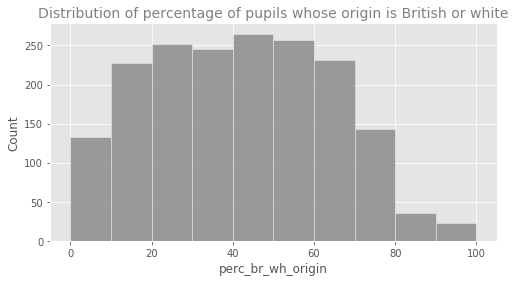

In [23]:
distribution('perc_br_wh_origin','gray','Distribution of percentage of pupils whose origin is British or white', 10)

**Percentage of pupils whose origin is British or white**

Majority of the schools have at least 20% to 70% of pupils whose origin is British or white.

Mean and median is almost the same, 41.8%-41.9%, the distribution is even across London.

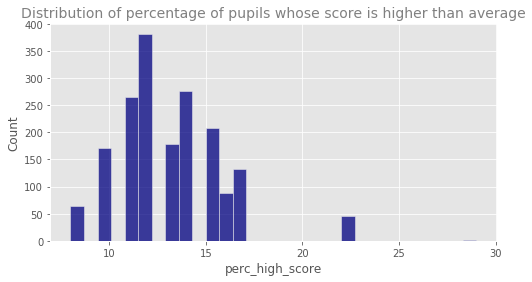

In [26]:
distribution('perc_high_score','navy','Distribution of percentage of pupils whose score is higher than average',30)

**Percentage of pupils whose score is higher than average**

Majority of schools have 12% of pupils whose score is higher than average. 

There are 46 schools where more than 20% of pupils have high score. The highest percentage is in Sir John Cass's Foundation Primary School in City of London, 29%.

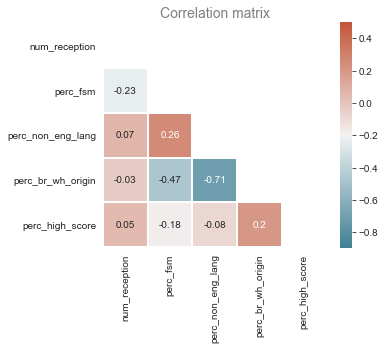

In [55]:
#correlation matrix

corr = round(df.corr(),2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 8))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, square=True, annot = True, linewidth = 1,
                     cmap=cmap,cbar=True,cbar_kws={"shrink": .52},vmin=-0.9, vmax=0.5)
    title('Correlation matrix')

Correlation matrix shows that the highest negative dependency is between `percentage of pupils of white origin` and `percentage of pupils whose first language is not English`. This makes sense as the more pupils are white / British the higher is percentage of first language being English (or lower percentage of students whose first language is NOT English).

Also there is relatively high correlation between `percentage of pupils of white origin` and `percentage of students receiving  free school meals` (-0.47), the higher is number of pupils of white origin the lower is percentage of students receiving benefits from the government.

Low positive correlation can be noted between `percentage of pupils of white origin` and `percentage of students receiving high scores`. Also the higher is `percentage of students receiving free school meals` the higher is `percentage of students whose first language is not English`.

Overall, it should be stressed out that this statistics is only for one period, therefore to draw more reliable conclusion more periods should be analyzed. 

Let's create subset of local authority areas with the following parameters:
- number of schools, 
- median number of pupils in the reception class, 
- median percentage of pupils with FSM (free school meals), 
- median percentage of pupils of white origin and 
- median percentage of pupils with English being not the first language 
- median percentage of pupils achieving a high score in reading and maths and working at greater depth in writing

We will add these parameters on the map.

In [ ]:
number_of_schools_in_la = df.groupby('la').agg({'urn':'count',
                                                'num_reception':'median',
                                                'perc_fsm':'median',
                                                'perc_br_wh_origin':'median',
                                                'perc_non_eng_lang':'median',
                                               'perc_high_score':'median'}).reset_index()
number_of_schools_in_la.columns = ['la', 'num_schools', 'num_reception', 'perc_fsm', 'perc_br_wh_origin',
       'perc_non_eng_lang', 'perc_high_score']
number_of_schools_in_la.head(5)

In [ ]:
number_of_schools_in_la

### Choropleth map

Let's create heatmap using json file.

In [ ]:
with urlopen('https://skgrange.github.io/www/data/london_boroughs.json') as response:
    geo = json.load(response)

#Let us check the keys of this JSON
geo["features"][0].keys()

In [ ]:
#The properties key should contain the district name. Let’s verify that
display(geo["features"][0]['properties'].keys())

#check the precision of the coordinates
geo["features"][0]['geometry']['coordinates'][0][0][0]

In [ ]:
#names of the boroughs to extract
geo_names = [geo['features'][k]['properties']['name'] for k in range(len(geo['features']))]

#The list sources contains the coordinates for all parts of the city. 
#We will later hand over this list to the Mapbox object in order to present the respective districts
source=[{"type": "Feature", 'features': [feat]} for feat in geo['features']]

In [ ]:
#create choropleth map with buttons

kwargs = dict(geojson=geo, locations=number_of_schools_in_la.la, z=number_of_schools_in_la.num_schools,
              colorscale="YlGnBu", zmin=number_of_schools_in_la.num_schools.min(), 
              zmax=number_of_schools_in_la.num_schools.max(), 
              featureidkey="properties.name", marker_opacity=0.5, marker_line_width=0)

switch_args = [dict(z = number_of_schools_in_la.perc_fsm, colorscale = 'YlGnBu', 
                    zmin=number_of_schools_in_la.perc_fsm.min(), zmax=number_of_schools_in_la.perc_fsm.max()),
              dict(z = number_of_schools_in_la.num_reception, colorscale = 'YlGnBu',
                   zmin=number_of_schools_in_la.num_reception.min(), zmax=number_of_schools_in_la.num_reception.max())]

buttons = [dict(label = 'total number of schools', method = 'restyle', args = [{'visible': [True, False, False]}]),
           dict(label = 'median percentage of FSM', method = 'restyle', args = [{'visible': [False, True, False]}]),
           dict(label = 'median number of pupils at reception', method = 'restyle', args = [{'visible': [False, False, True]}])]

objects = [go.Choroplethmapbox(visible = True,**kwargs)]
for i in [0, 1]:
    kwargs.update(switch_args[i])
    objects.append(go.Choroplethmapbox(visible = False,**kwargs))
    
fig = go.Figure(data = objects)

fig.update_layout()
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=8.5, mapbox_center = {"lat": 51.5074, "lon": 0.1278},
                  margin={"r":0,"t":100,"l":0,"b":0}, title = dict(text = 'LONDON MAP', font_size = 20),
                  annotations = [dict(text = 'Parameter:', yref = 'paper', yanchor = 'middle', xref = 'paper', 
                                      xanchor = 'right', showarrow = False, font_size = 16, y = 1.055, x = 0.15)],
                  updatemenus = [dict(type = 'buttons', direction = 'right', showactive = True, 
                                      y = 1.05, yanchor = 'middle', x = 0.165, xanchor = 'left', buttons = buttons)])
fig.show()

In [ ]:
#create choropleth map with buttons

kwargs = dict(geojson=geo, locations=number_of_schools_in_la.la, z=number_of_schools_in_la.perc_br_wh_origin,
              colorscale="YlGnBu", zmin=number_of_schools_in_la.perc_br_wh_origin.min(), 
              zmax=number_of_schools_in_la.perc_br_wh_origin.max(), 
              featureidkey="properties.name", marker_opacity=0.5, marker_line_width=0)

switch_args = [dict(z = number_of_schools_in_la.perc_non_eng_lang, colorscale = 'YlGnBu', 
                    zmin=number_of_schools_in_la.perc_non_eng_lang.min(), 
                    zmax=number_of_schools_in_la.perc_non_eng_lang.max()),
              dict(z = number_of_schools_in_la.perc_high_score, colorscale = 'YlGnBu',
                   zmin=number_of_schools_in_la.perc_high_score.min(), 
                   zmax=number_of_schools_in_la.perc_high_score.max())]

buttons = [dict(label = 'median percentage of white origin', method = 'restyle', 
                args = [{'visible': [True, False, False]}]),
           dict(label = 'median percentage of English not being first language', 
                method = 'restyle', args = [{'visible': [False, True, False]}]),
           dict(label = 'median percentage of pupils achieving a high score', method = 'restyle', 
                args = [{'visible': [False, False, True]}])]

objects = [go.Choroplethmapbox(visible = True,**kwargs)]
for i in [0, 1]:
    kwargs.update(switch_args[i])
    objects.append(go.Choroplethmapbox(visible = False,**kwargs))
    
fig = go.Figure(data = objects)

fig.update_layout()
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=8.5, mapbox_center = {"lat": 51.5074, "lon": 0.1278},
                  margin={"r":0,"t":100,"l":0,"b":0}, title = dict(text = 'LONDON MAP', font_size = 20),
                  annotations = [dict(text = 'Parameter:', yref = 'paper', yanchor = 'middle', xref = 'paper', 
                                      xanchor = 'right', showarrow = False, font_size = 16, y = 1.055, x = 0.15)],
                  updatemenus = [dict(type = 'buttons', direction = 'right', showactive = True, 
                                      y = 1.05, yanchor = 'middle', x = 0.165, xanchor = 'left', buttons = buttons)])
fig.show()

In [ ]:
number_of_schools_in_la.H

## Results

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(23, 10))
fig.suptitle('category', size = 20, color = 'gray')
sns.histplot(ax = axes[0,0], data = df, x = 'num_reception', hue = 'size')
sns.histplot(ax = axes[0,1], data = df, x = '%_fcm', hue = 'size')
sns.histplot(ax = axes[1,0], data = df, x = '%_br_wh_origin', hue = 'size')
sns.histplot(ax = axes[1,1], data = df, x = '%_non_eng_lang, hue = 'size'')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [ ]:
df.groupby('size')['urn'].count().reset_index().sort_values(by = 'size')